<a href="https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-i-auto-encoder?scriptVersionId=134186748" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exploring Auto-encoders, Variational Auto-encoders and GANs for Images
# Part I - Auto-encoders

In the excellent book _Hands on Machine Learning with Scikit-Learn, Keras, & Tensorflow_, Chapter 17 discusses autoencoders, variational autoencoders, and GANs.  The problems at the end of the chapter do not have answers provided, so I decided to try my hand at them.  Question 10 asks the reader to develop a variational autoencoder with an image dataset and use it to generate images.  Question 11 extends this to generating new images using a GAN.

In Part I, I start by generating a frequentist auto-encoder.

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I develop a Variational Auto-encoder and show randomly generated images as well as imagest representing the average encoding for each class.

In [Part III](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-iii-gan), I will finish with a Generative Adversarial Network.

You can find code for the book [here](https://github.com/ageron/handson-ml2), and my Github repository with my answers to exercises [here](https://github.com/KirkDCO/HandsOnML_Exercises).

## Finding an image dataset
For this exercise, I wanted to find an interesting image dataset that was not too complex but also not too simple.  A dataset with RGB images would also be nice.  After much searching through the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview) and [Kaggle Datasets](https://www.kaggle.com/datasets), I found the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers) consisting of 13,838 JPEG 96 x 96 images of 14 different flowers.  (The dataset changed with the addtion of a new flower type while I was working on this notebook, so the latest version may not match the numbers of files I've quoted or that you see in outputs, below.)  I added the dataset directly to this notebook from its location on Kaggle.

First step is to import needed packages, set up global variables, and create generators for the flower images.

In [1]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32 

IMG_WIDTH  = 96 
IMG_HEIGHT = 96 

ENCODING_SIZE = 8 

In [2]:
# create a flower generator with labels
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling here
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)


Found 15740 files belonging to 16 classes.
Found 15740 files belonging to 1 classes.
Using 12592 files for training.
Found 15740 files belonging to 1 classes.
Using 3148 files for validation.


Taking a look at a few random images from the dataset we see that most of the images are nicely centered and often there is just one flower per image.  In some cases there are many flowers in a bouquet or bunch, or there are other background elements in image.  Dandelions are interesting as they may have the yellow flower or the white puffball seed stage.

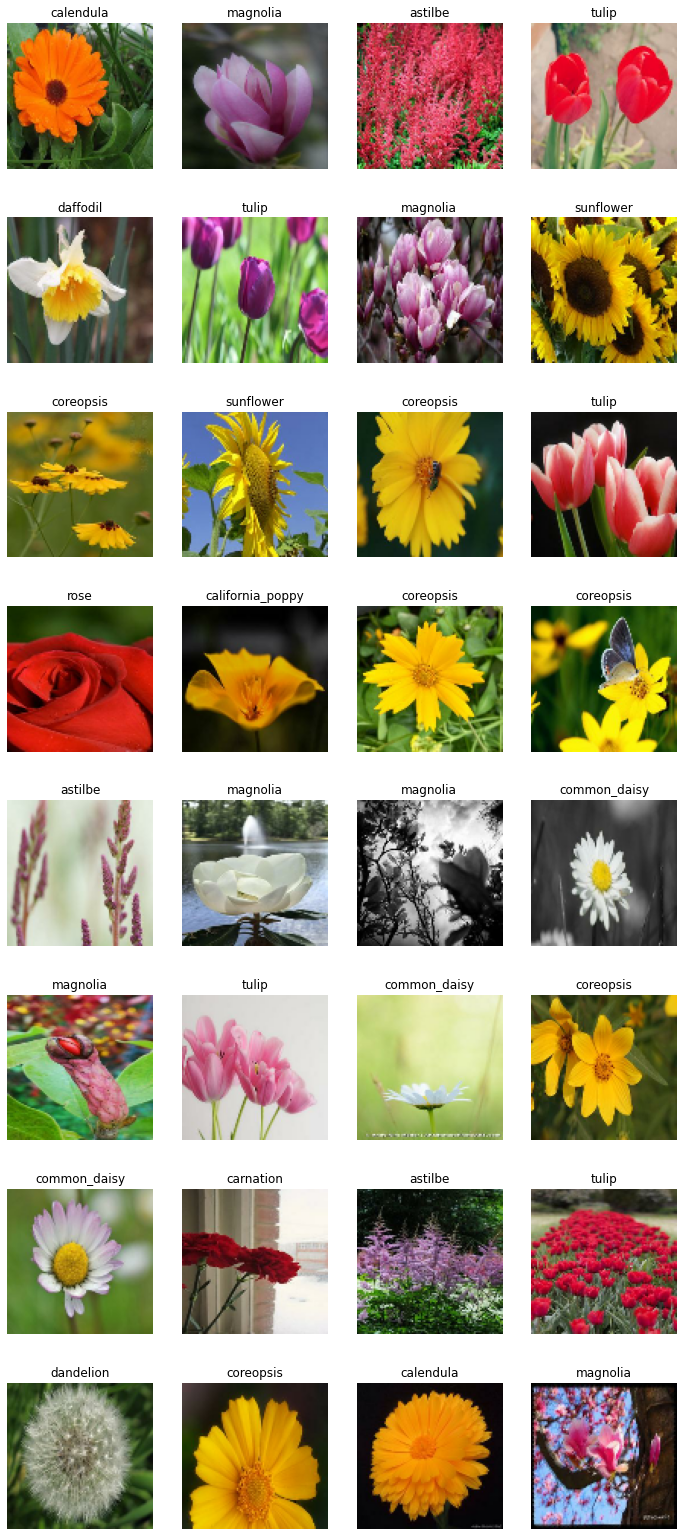

In [3]:
# visualize a few random flowers
plt.figure(figsize=(12, 28))

for images, labels in flower_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(flower_names[labels[i]])
      plt.axis("off")

## Convolutional Autoencoder

I wanted to see how a convolutional autoencoder would perform with respect to image reconstruction.  I created a very simple 3 stage convolutional autoencoder consiting of 32 features for the original  96 x 96 RGB imgaes, followed by Max Pooling and 64 features for the 48 x 48 x 32 feature map, another Max Pooling step and finally 128 features for the 24 x 24 x 32 feature map.  I tried a number of different encoding layer sizes and found 1024 to produce better results that 512, and nearly as good as 2048.  

In [4]:
ENCODING_SIZE = 1024

# build a convolutional auto-encoder 
encoder = keras.models.Sequential([
            keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(64, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(128, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(ENCODING_SIZE)
])

encoder.summary()

decoder = keras.models.Sequential([
            keras.layers.Dense(128 * 24 * 24 , activation = "relu", input_shape = [ENCODING_SIZE]),
            keras.layers.Reshape([24, 24, 128]),
            keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, 
                                         padding = 'same', activation = 'sigmoid')
])

decoder.summary()

ae = keras.models.Sequential([encoder, decoder])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              7

In [5]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

# compile and run
ae.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Nadam())
history = ae.fit(X_train, validation_data = X_valid,  epochs = 25, \
                 callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/25
394/394 [==============================] - 45s 92ms/step - loss: 0.0423 - val_loss: 0.0298
Epoch 2/25
394/394 [==============================] - 32s 81ms/step - loss: 0.0252 - val_loss: 0.0227
Epoch 3/25
394/394 [==============================] - 32s 80ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 4/25
394/394 [==============================] - 32s 81ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 5/25
394/394 [==============================] - 32s 82ms/step - loss: 0.0147 - val_loss: 0.0151
Epoch 6/25
394/394 [==============================] - 32s 81ms/step - loss: 0.0132 - val_loss: 0.0141
Epoch 7/25
394/394 [==============================] - 32s 81ms/step - loss: 0.0121 - val_loss: 0.0136
Epoch 8/25
394/394 [==============================] - 32s 81ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 9/25
394/394 [==============================] - 32s 80ms/step - loss: 0.0105 - val_loss: 0.0130
Epoch 10/25
394/394 [==============================] - 32s 81ms/step - loss: 0.009

Looking at the reconstructions for a few random flowers, they look quite good. Trying larger encoding (2048) didn't produce substantially better results, and smaller encodings (512) produced somewhat degraded results.

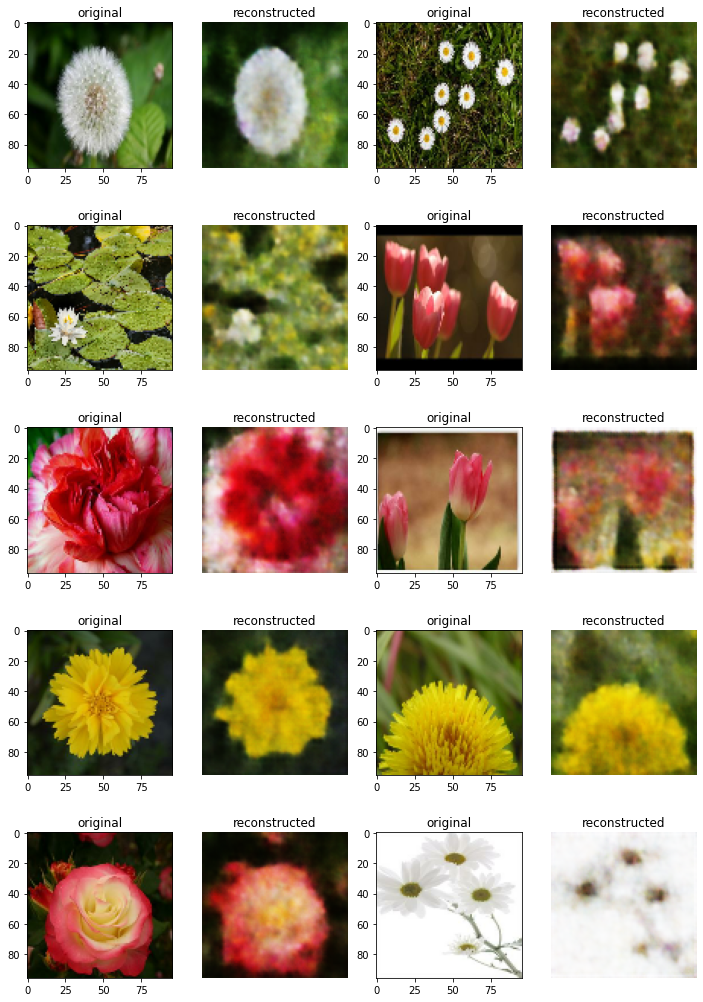

In [6]:
# visualize a few random flowers
# and their reconstructions
plt.figure(figsize=(12, 18))

for images, _ in X_valid.take(1):
  ae_images = ae.predict(images)
  for i in range(10):
    ax = plt.subplot(5, 4, (i * 2) + 1)
    plt.imshow(images[i])
    plt.title('original')

    ax = plt.subplot(5, 4, (i * 2) + 2)
    plt.imshow(ae_images[i])
    plt.title('reconstructed')
    plt.axis("off")

## Conclusions

Creating a convolutional autoencoder was quite simple.  The most time consuming part was experimentation to deterimine the overall network atchitecture - how many convolutional layers, how many features per layer, size of encoding layer.  Each new architecture change required training time.  Comparison of the results was much faster and consisted of simple visual comparison rather than a computational metric approach.

## Next Up

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I will use this same dataset to develp a Variational Autoencoder and make an attempt at randomly generated flowers.